# Introduction

In this notebook we aim to determine what parts of the pMHC, if any, move when contacted by TCRs. We split the MHC domain into MHC-non-TCR contact and MHC-TCR contact based on previous analysis of the TCR finger print on the MHC molecules.

In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

In [2]:
NOISE_LEVEL = 0.5 # Å

# Load comparisons

In [3]:
results = pd.read_csv('../data/processed/apo-holo-tcr-pmhc-class-I-comparisons/pmhc_tcr_contact_apo_holo.csv')
results

,complex_id,structure_x_name,structure_y_name,chain_type,tcr_contact,rmsd
0,3qdg_D-E-C-A-B_tcr_pmhc,1jf1_A-B-C_pmhc.pdb,3qdg_D-E-C-A-B_tcr_pmhc.pdb,mhc_chain1,False,0.630013
1,3qdg_D-E-C-A-B_tcr_pmhc,1jf1_A-B-C_pmhc.pdb,3qdg_D-E-C-A-B_tcr_pmhc.pdb,mhc_chain1,True,0.582077
2,7ow6_D-E-C-A-B_tcr_pmhc,7ow4_A-B-C_pmhc.pdb,7ow4_D-E-F_pmhc.pdb,antigen_chain,False,0.349159
3,7ow6_D-E-C-A-B_tcr_pmhc,7ow4_A-B-C_pmhc.pdb,7ow4_D-E-F_pmhc.pdb,mhc_chain1,False,0.306333
4,7ow6_D-E-C-A-B_tcr_pmhc,7ow4_A-B-C_pmhc.pdb,7ow4_D-E-F_pmhc.pdb,mhc_chain1,True,0.265103
...,...,...,...,...,...,...
1989,7rtr_D-E-C-A-B_tcr_pmhc,7p3d_A-B-C_pmhc.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,mhc_chain1,False,0.497769
1990,7rtr_D-E-C-A-B_tcr_pmhc,7p3d_A-B-C_pmhc.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,mhc_chain1,True,0.458372
1991,7rtr_D-E-C-A-B_tcr_pmhc,7rtd_A-B-C_pmhc.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,antigen_chain,False,0.455078
1992,7rtr_D-E-C-A-B_tcr_pmhc,7rtd_A-B-C_pmhc.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,mhc_chain1,False,0.449558


In [4]:
results_holo_holo = pd.read_csv('../data/processed/apo-holo-tcr-pmhc-class-I-comparisons/pmhc_tcr_contact_holo.csv')

In [5]:
results_holo_holo = results_holo_holo.query("chain_type == 'mhc_chain1' or chain_type == 'antigen_chain'")

In [6]:
results_holo_holo['mhc_slug'] = None
results_holo_holo['peptide_sequence'] = None

In [7]:
mhc_pattern = r'^hla|h2'
mhc_complex_ids = results_holo_holo['complex_id'].str.contains(mhc_pattern, regex=True)

mhc_slug_peptides = results_holo_holo[mhc_complex_ids]['complex_id'].str.rsplit('_', n=1)
mhc_slugs = mhc_slug_peptides.map(lambda composite: composite[0])
peptides = mhc_slug_peptides.map(lambda composite: composite[1])

results_holo_holo.loc[mhc_complex_ids, 'mhc_slug'] = mhc_slugs
results_holo_holo.loc[mhc_complex_ids, 'peptide_sequence'] = peptides

results_holo_holo = results_holo_holo[mhc_complex_ids]

## Load summary data

In [10]:
apo_holo_summary_df = pd.read_csv('../data/processed/apo-holo-tcr-pmhc-class-I/apo_holo_summary.csv')
apo_holo_summary_df

,file_name,pdb_id,structure_type,state,alpha_chain,beta_chain,antigen_chain,mhc_chain1,mhc_chain2,cdr_sequences_collated,peptide_sequence,mhc_slug
0,1ao7_D-E-C-A-B_tcr_pmhc.pdb,1ao7,tcr_pmhc,holo,D,E,C,A,B,DRGSQS-IYSNGD-AVTTDSWGKLQ-MNHEY-SVGAGI-ASRPGLA...,LLFGYPVYV,hla_a_02_01
1,1bd2_D-E-C-A-B_tcr_pmhc.pdb,1bd2,tcr_pmhc,holo,D,E,C,A,B,NSMFDY-ISSIKDK-AAMEGAQKLV-MNHEY-SVGAGI-ASSYPGG...,LLFGYPVYV,hla_a_02_01
2,1bii_A-B-P_pmhc.pdb,1bii,pmhc,apo,NaN,NaN,P,A,B,NaN,RGPGRAFVTI,h2_dd
3,1ddh_A-B-P_pmhc.pdb,1ddh,pmhc,apo,NaN,NaN,P,A,B,NaN,RGPGRAFVTI,h2_dd
4,1duz_A-B-C_pmhc.pdb,1duz,pmhc,apo,NaN,NaN,C,A,B,NaN,LLFGYPVYV,hla_a_02_01
...,...,...,...,...,...,...,...,...,...,...,...,...
353,8gon_D-E-C-A-B_tcr_pmhc.pdb,8gon,tcr_pmhc,holo,D,E,C,A,B,TSESDYY-QEAYKQQN-ASSGNTPLV-SGHNS-FNNNVP-ASTWGR...,NaN,NaN
354,8gop_A-B_tcr.pdb,8gop,tcr,apo,A,B,NaN,NaN,NaN,TSESDYY-QEAYKQQN-ASSGNTPLV-SGHNS-FNNNVP-ASTWGR...,NaN,NaN
355,8gvb_A-B-P-H-L_tcr_pmhc.pdb,8gvb,tcr_pmhc,holo,A,B,P,H,L,YGATPY-YFSGDTLV-AVGFTGGGNKLT-SEHNR-FQNEAQ-ASSD...,RYPLTFGW,hla_a_24_02
356,8gvg_A-B-P-H-L_tcr_pmhc.pdb,8gvg,tcr_pmhc,holo,A,B,P,H,L,YGATPY-YFSGDTLV-AVGFTGGGNKLT-SEHNR-FQNEAQ-ASSD...,RFPLTFGW,hla_a_24_02


In [11]:
apo_holo_summary_df['ids'] = apo_holo_summary_df['file_name'].str.replace('.pdb$', '')

/var/scratch/bmcmaste/1757795/ipykernel_1746162/477882467.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  apo_holo_summary_df['ids'] = apo_holo_summary_df['file_name'].str.replace('.pdb$', '')


## Annotate results with summary data

In [12]:
results = results.merge(apo_holo_summary_df[['ids', 'cdr_sequences_collated', 'peptide_sequence', 'mhc_slug']],
                        left_on='complex_id',
                        right_on='ids',
                        how='left')

In [13]:
results = pd.concat([results, results_holo_holo])

In [14]:
results = results.merge(
    apo_holo_summary_df[['file_name', 'pdb_id', 'structure_type', 'state']],
    how='left',
    left_on='structure_x_name',
    right_on='file_name',
).merge(
    apo_holo_summary_df[['file_name', 'pdb_id', 'structure_type', 'state']],
    how='left',
    left_on='structure_y_name',
    right_on='file_name',
)

In [16]:
def name_domain(chain_type: str, tcr_contact: bool) -> str | None:
    match chain_type:
        case 'antigen_chain':
            return 'peptide'

        case 'mhc_chain1':
            if tcr_contact:
                return 'mhc_tcr_contact'

            return 'mhc'

    return None

results['domain'] = results.apply(lambda row: name_domain(row.chain_type, row.tcr_contact), axis='columns')

In [18]:
results['comparison'] = results['state_x'] + '-' + results['state_y']
results['comparison'] = results['comparison'].map(lambda entry: 'apo-holo' if entry == 'holo-apo' else entry)

In [19]:
results['structure_comparison'] = results.apply(
    lambda row: '-'.join(sorted([row.structure_x_name, row.structure_y_name])),
    axis='columns',
)
results = results.drop_duplicates(['structure_comparison', 'domain'])

In [21]:
results = results.groupby(['peptide_sequence',
                           'mhc_slug',
                           'comparison',
                           'domain'], dropna=False)['rmsd'].mean().reset_index()

In [23]:
apo_holo_results = results.query("comparison == 'apo-holo'")

In [24]:
apo_holo_results

,peptide_sequence,mhc_slug,comparison,domain,rmsd
3,AAGIGILTV,hla_a_02_01,apo-holo,mhc,0.660376
4,AAGIGILTV,hla_a_02_01,apo-holo,mhc_tcr_contact,0.562211
5,AAGIGILTV,hla_a_02_01,apo-holo,peptide,1.025622
9,ALHGGWTTK,hla_a_03_01,apo-holo,mhc,0.442792
10,ALHGGWTTK,hla_a_03_01,apo-holo,mhc_tcr_contact,0.990352
...,...,...,...,...,...
339,YGFRNVVHI,h2_db,apo-holo,mhc_tcr_contact,0.829133
340,YGFRNVVHI,h2_db,apo-holo,peptide,0.275006
344,YLQPRTFLL,hla_a_02_01,apo-holo,mhc,0.647465
345,YLQPRTFLL,hla_a_02_01,apo-holo,mhc_tcr_contact,0.476928


# Visualise results

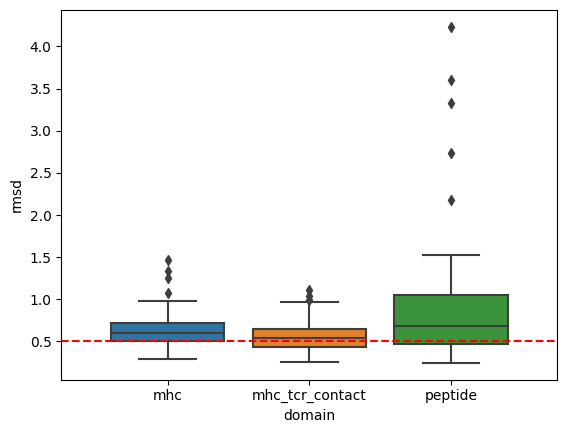

In [25]:
sns.boxplot(apo_holo_results, x='domain', y='rmsd')

x = np.linspace(-0.75, 2.75)
y = np.repeat(NOISE_LEVEL, len(x))

plt.plot(x, y, '--r')
plt.xlim(-0.75, 2.75)

plt.savefig('../report/figures/pmhc_movement_by_component.svg')

# Compute Statistics

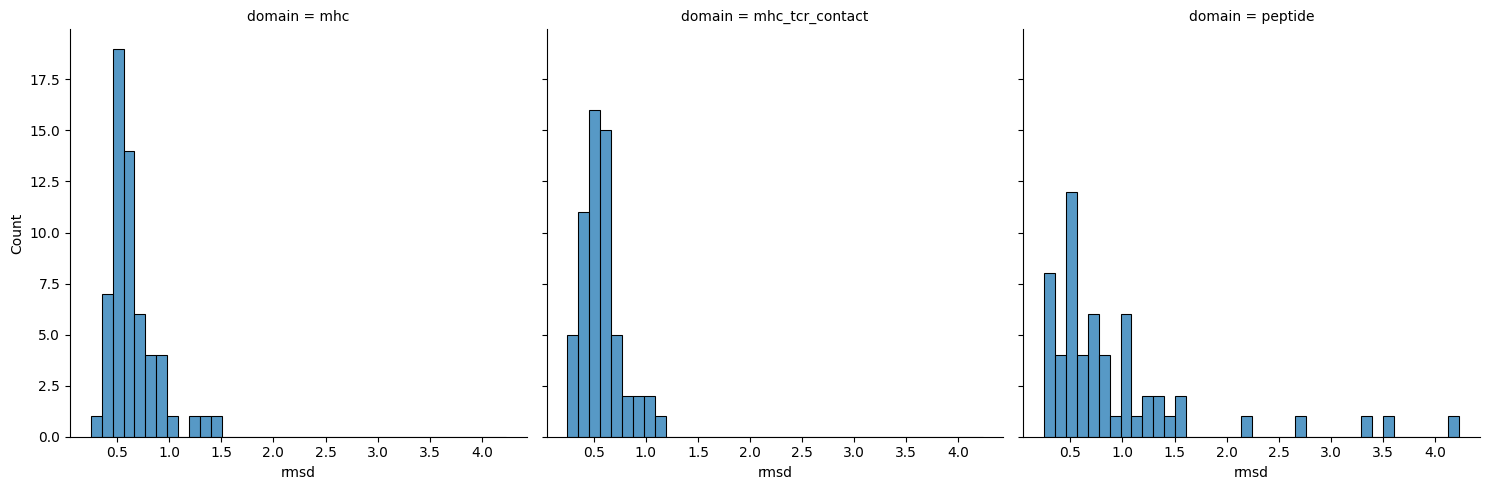

In [26]:
sns.displot(apo_holo_results, x='rmsd', col='domain')

In [27]:
conditions = {domain: apo_holo_results[apo_holo_results['domain'] == domain]['rmsd'].values for domain in apo_holo_results['domain'].unique()}

In [28]:
scipy.stats.f_oneway(*conditions.values())

F_onewayResult(statistic=8.43958931017577, pvalue=0.0003181981364846825)

In [29]:
combos = list(itertools.combinations(conditions.items(), 2))

significane_level = 0.05 / len(combos)

ad_hoc_results = {'condition_x': [], 'condition_y': [], 'stat': [], 'p_val': []}
for (condition_x_name, condition_x), (condition_y_name, condition_y) in combos:
    ad_hoc_results['condition_x'].append(condition_x_name)
    ad_hoc_results['condition_y'].append(condition_y_name)

    stat, p_val = scipy.stats.ttest_ind(condition_x, condition_y)

    ad_hoc_results['stat'].append(stat)
    ad_hoc_results['p_val'].append(p_val)

ad_hoc_results = pd.DataFrame(ad_hoc_results)

ad_hoc_results['significant'] = ad_hoc_results['p_val'] < significane_level

ad_hoc_results

,condition_x,condition_y,stat,p_val,significant
0,mhc,mhc_tcr_contact,2.116838,0.036411,False
1,mhc,peptide,-2.531661,0.012702,True
2,mhc_tcr_contact,peptide,-3.322653,0.001196,True


Based on these results it seems that the peptide undergoes conformational change but not the MHC molecule- either TCR-contacting or not.

# Comparing the differences in binding between movement types

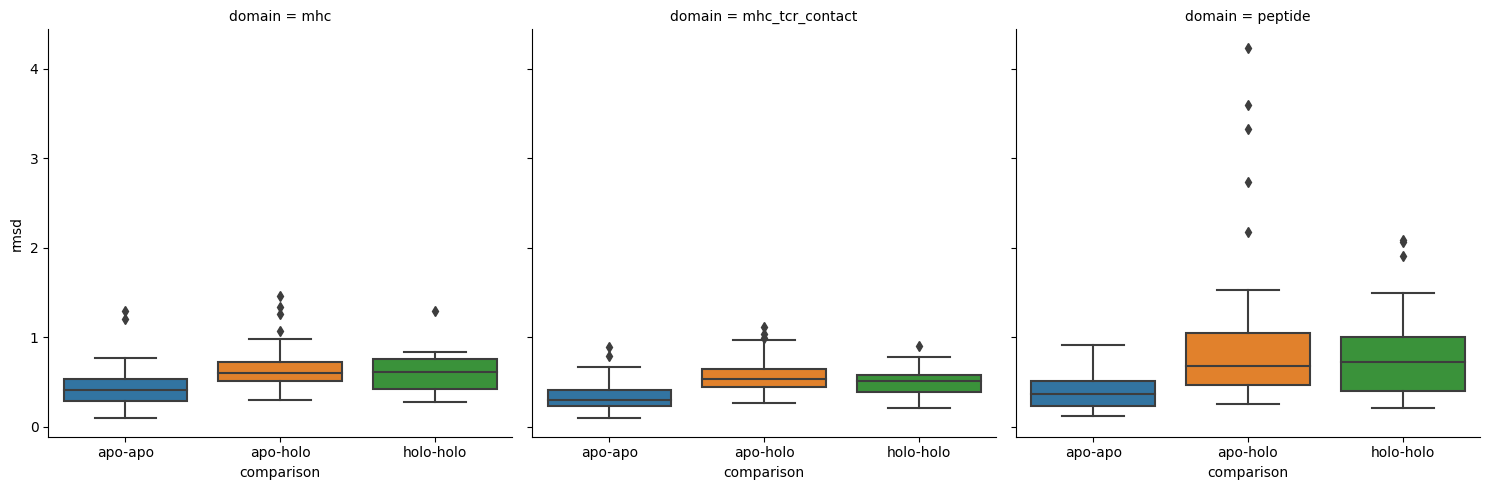

In [30]:
sns.catplot(results,
            x='comparison', y='rmsd',
            col='domain',
            kind='box')

plt.savefig('../report/figures/pmhc_domain_movement_comparison.svg')

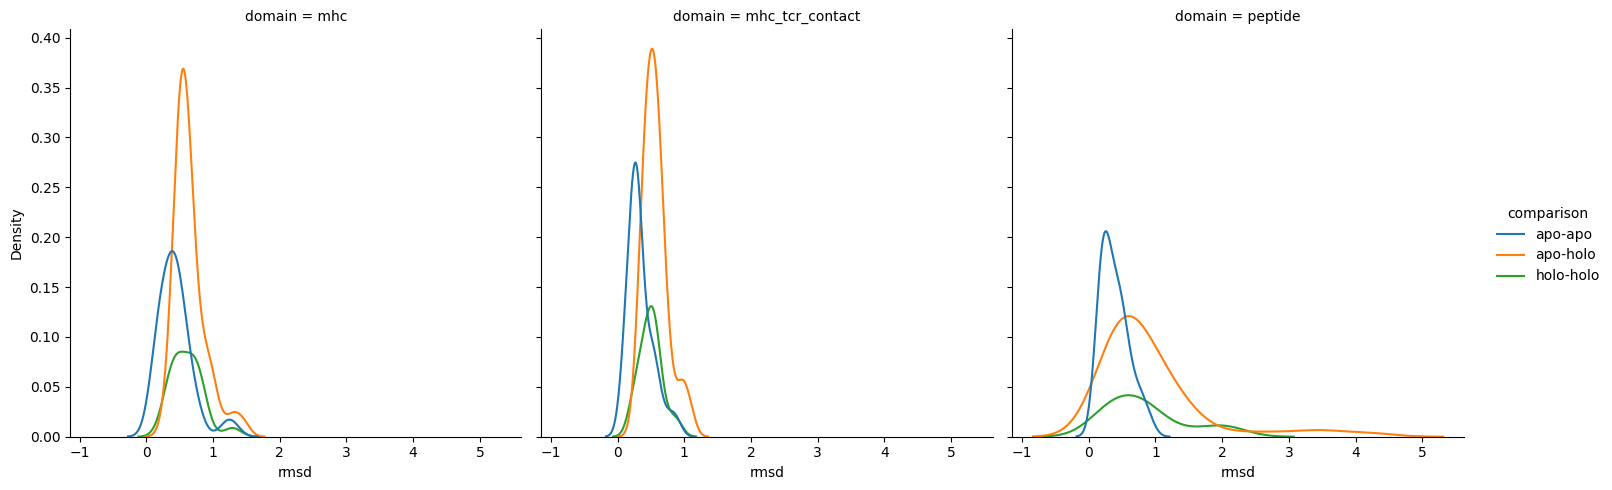

In [31]:
sns.displot(results,
            hue='comparison', x='rmsd',
            col='domain',
            kind='kde')

In [32]:
treatment_options = ['comparison', 'domain']
treatments = [(group, df['rmsd'].to_numpy()) for group, df in results.groupby(treatment_options)]
treatments
print(scipy.stats.kruskal(*[values for _, values in treatments]))

KruskalResult(statistic=89.32014468652255, pvalue=6.389533459621575e-16)


In [33]:
combos = []
for pairing in list(itertools.combinations(treatments, 2)):
    domain_x = pairing[0][0][1]
    domain_y = pairing[1][0][1]

    if domain_x == domain_y:
        combos.append(pairing)

significance_level = 0.05 / len(combos)
print(significance_level)
statistics = []
p_vals = []

for ((comparison_x, domain_x), sample_x), ((comparison_y, domain_y), sample_y) in combos:
    stat, p_val = scipy.stats.ranksums(sample_x, sample_y)

    statistics.append(stat)
    p_vals.append(p_val)

momvement_type_statistics = pd.DataFrame({
    'comparison_x': [name for ((name, _,), _), _ in combos],
    'domain_x': [name for ((_, name), _), _ in combos],
    'comparison_y': [name for _, ((name, _), _) in combos],
    'domain_y': [name for _, ((_, name), _) in combos],
    'statistic': statistics,
    'p_val': p_vals,
    'significant': [p_val < significance_level for p_val in p_vals],
})

momvement_type_statistics['p_val'] = momvement_type_statistics['p_val'].map(lambda num: f'{num:.2e}')

momvement_type_statistics

0.005555555555555556


,comparison_x,domain_x,comparison_y,domain_y,statistic,p_val,significant
0,apo-apo,mhc,apo-holo,mhc,-4.766718,1.87e-06,True
1,apo-apo,mhc,holo-holo,mhc,-2.895550,3.78e-03,True
2,apo-apo,mhc_tcr_contact,apo-holo,mhc_tcr_contact,-5.550086,2.86e-08,True
3,apo-apo,mhc_tcr_contact,holo-holo,mhc_tcr_contact,-3.288167,1.01e-03,True
4,apo-apo,peptide,apo-holo,peptide,-5.087082,3.64e-07,True
5,apo-apo,peptide,holo-holo,peptide,-3.533553,4.10e-04,True
6,apo-holo,mhc,holo-holo,mhc,0.687756,4.92e-01,False
7,apo-holo,mhc_tcr_contact,holo-holo,mhc_tcr_contact,1.409336,1.59e-01,False
8,apo-holo,peptide,holo-holo,peptide,0.228864,8.19e-01,False


# Conclusion

This analysis reveals that the peptide undergoes the most change from *apo* to *holo* states and the MHC molecule has little change between these states. It does not matter whether it is the TCR contacting portion of the MHC or not. The statistical analysis comparing the differences between comparion types gives inconclusive results.